In [2]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from dateutil import parser
import calendar
import traceback

trip_data = pd.read_pickle("data/trips.pkl")

trip_data.head()


,bike_id,duration,start_station_id,end_station_id,start_str,end_str,start_dt,start_day,start_month,start_year,start_hour,start_day_of_week,start_ts,end_dt,end_day,end_month,end_year,end_hour,end_day_of_week,end_ts
0,11834,240,18,383.0,10/01/2016 00:00,10/01/2016 00:04,2016-01-10 00:00:00,10,01,2016,00,Sunday,1452384000,2016-01-10 00:04:00,10,01,2016,00,Sunday,1452384240
1,9648,300,479,719.0,10/01/2016 00:00,10/01/2016 00:05,2016-01-10 00:00:00,10,01,2016,00,Sunday,1452384000,2016-01-10 00:05:00,10,01,2016,00,Sunday,1452384300
2,10689,1200,425,272.0,10/01/2016 00:00,10/01/2016 00:20,2016-01-10 00:00:00,10,01,2016,00,Sunday,1452384000,2016-01-10 00:20:00,10,01,2016,00,Sunday,1452385200
3,8593,780,487,471.0,10/01/2016 00:01,10/01/2016 00:14,2016-01-10 00:01:00,10,01,2016,00,Sunday,1452384060,2016-01-10 00:14:00,10,01,2016,00,Sunday,1452384840
4,8619,600,501,399.0,10/01/2016 00:01,10/01/2016 00:11,2016-01-10 00:01:00,10,01,2016,00,Sunday,1452384060,2016-01-10 00:11:00,10,01,2016,00,Sunday,1452384660


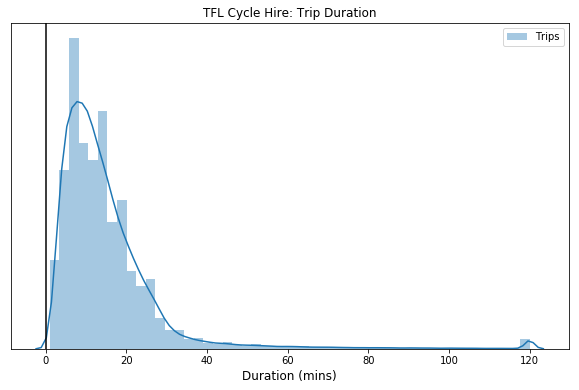

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

cutoff_hours = 2*60*60

series = trip_data['duration']
series = series[series > 0].dropna()
series[(series > cutoff_hours)] = cutoff_hours
series = series / 60

sns.distplot(series, label="Trips")
plt.title("TFL Cycle Hire: Trip Duration", fontsize=12)
plt.legend(loc='upper right')
plt.axvline(0, color='black')
plt.xlabel("Duration (mins)", fontsize=12)
ax.yaxis.set_visible(False)
plt.ylabel("")
plt.show()